# Projekt - Data Engineering na przykładzie Titanic

---
## 1 - Środowisko

- Utwórz sesję spark i pobierz plik z danymi https://www.kaggle.com/api/v1/datasets/download/sakshisatre/titanic-dataset. Uwaga - plik trzeba rozkompresować
- Wyświetl przykładowe rekordy, wyświetl schemat, wyświetl podstawowe informacje statystyczne, policz liczbę rekordów.

---

Utwórz sesję spark

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("myApp").master("local[*]").getOrCreate()

Pobierz plik https://www.kaggle.com/api/v1/datasets/download/hesh97/titanicdataset-traincsv i zapisz go lokalnie. Opis pliku znajdziesz na stronie: https://www.kaggle.com/datasets/sakshisatre/titanic-dataset?select=Titanic+Dataset.csv. Zapoznaj się z nim.

Plik jest również dołączony do materiałów kursowych


In [2]:
#!/bin/bash
! curl -L -o data.zip https://www.kaggle.com/api/v1/datasets/download/sakshisatre/titanic-dataset
! unzip data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60609  100 60609    0     0   110k      0 --:--:-- --:--:-- --:--:--     0
Archive:  data.zip
  inflating: The Titanic dataset.csv  
  inflating: Titanic Dataset.csv     


Wczytaj zawartość pliku "Titanic Dataset.csv" do data frame o nazwie titanic. W pierwszym wierszu znajdują sie nagłówki i należy "wydedukować" schemat danych

In [3]:
titanic = spark.read.csv("Titanic Dataset.csv", inferSchema=True, header=True)
titanic.show(3)

+------+--------+--------------------+------+----+-----+-----+------+--------+-------+--------+----+----+--------------------+
|pclass|survived|                name|   sex| age|sibsp|parch|ticket|    fare|  cabin|embarked|boat|body|           home.dest|
+------+--------+--------------------+------+----+-----+-----+------+--------+-------+--------+----+----+--------------------+
|     1|       1|Allen, Miss. Elis...|female|29.0|    0|    0| 24160|211.3375|     B5|       S|   2|NULL|        St Louis, MO|
|     1|       1|Allison, Master. ...|  male|0.92|    1|    2|113781|  151.55|C22 C26|       S|  11|NULL|Montreal, PQ / Ch...|
|     1|       0|Allison, Miss. He...|female| 2.0|    1|    2|113781|  151.55|C22 C26|       S|NULL|NULL|Montreal, PQ / Ch...|
+------+--------+--------------------+------+----+-----+-----+------+--------+-------+--------+----+----+--------------------+
only showing top 3 rows



Sprawdź schemat data frame

In [4]:
titanic.printSchema()

root
 |-- pclass: integer (nullable = true)
 |-- survived: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sibsp: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: double (nullable = true)
 |-- cabin: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- body: integer (nullable = true)
 |-- home.dest: string (nullable = true)



Korzystając z metody describe() wyświetl informacje o licznie wierszy, średniej, odchyleniu standardowym, wartości minimalnej i maksymalnej dla każdej kolumny data frame.

Uwaga: nazwa ostatniej kolumny zawiera kropkę i będzie to przeszkadzać przy wykonywaniu operacji. Dlatego zmień nazwę kolumny home.dest na na home_dest. Oczywiście możesz sie najpierw przekonać na własnej skórze, co się stanie jeśli nazwa nie jest zmieniona.

In [5]:
titanic = titanic.withColumnRenamed("home.dest", "home_dest")
titanic.describe().show()

+-------+------------------+-------------------+--------------------+------+------------------+------------------+------------------+------------------+-----------------+-----+--------+------------------+-----------------+-------------------+
|summary|            pclass|           survived|                name|   sex|               age|             sibsp|             parch|            ticket|             fare|cabin|embarked|              boat|             body|          home_dest|
+-------+------------------+-------------------+--------------------+------+------------------+------------------+------------------+------------------+-----------------+-----+--------+------------------+-----------------+-------------------+
|  count|              1309|               1309|                1309|  1309|              1046|              1309|              1309|              1309|             1308|  295|    1307|               486|              121|                745|
|   mean| 2.294881588999236|

Policz ogolną liczbe wierszy w data frame. Zapisz ją w zmiennej titanic_count

In [6]:
titanic_count = titanic.count()
titanic_count

1309

---
## 2 - Ustalenie liczby wartości null

W celu ustalenia jakości danych, sprawdź ile jest wartości nullowych w poszczególnych kolumnach. Wyświetl tabelę z zawartością podobnej do poniższej. Zawartość kolumn to:

- nazwa kolumny
- liczba wartości nullowych
- procent wartości nullowych w tej kolumnie

|column_name|null_count|null_percentage|
|-----------|----------|---------------|
|       body|      1188|           90.8|
|      cabin|      1014|           77.5|
|       boat|       823|           62.9|
|  home_dest|       564|           43.1|
|        age|       263|           20.1|
|   embarked|         2|            0.2|
|       fare|         1|            0.1|
|     pclass|         0|            0.0|
|     ticket|         0|            0.0|
|   survived|         0|            0.0|
|       name|         0|            0.0|
|        sex|         0|            0.0|
|      sibsp|         0|            0.0|
|      parch|         0|            0.0|

---

Policzmy ile wartości nullowych znajduje się w poszczególnych kolumnach. W tym celu można:

- utworzyć pusty słownik np. null_counts
- przejść pętlą przez kolumny data frame titanic
- policzyć ile jest wartości nullowych w tej kolumnie i dodać wartość do słownika


In [7]:
from pyspark.sql.functions import col, sum

null_counts = {}

for c in titanic.columns:
  null_counts[c] = titanic.filter(col(c).isNull()).count()

null_counts

{'pclass': 0,
 'survived': 0,
 'name': 0,
 'sex': 0,
 'age': 263,
 'sibsp': 0,
 'parch': 0,
 'ticket': 0,
 'fare': 1,
 'cabin': 1014,
 'embarked': 2,
 'boat': 823,
 'body': 1188,
 'home_dest': 564}

Zamień uzyskany słownik na postać data frame. W tym celu:

- utwórz listę krotek (tuple) kluczy i wartości słownika - do tego można wykorzystać zwykłe konstrukcje języka Python, np. list coprehension
- korzystając z odpowiedniej metody obiektu sesji spark utwórz data frame null_counts_df
- wyświetlając data frame posortuj go wg liczby wartości nullowych per kolumna malejąco

In [8]:
from pyspark.sql.functions import desc

data = [(k, v) for k, v in null_counts.items()]
null_counts_df = spark.createDataFrame(data, ["column_name", "null_count"])

null_counts_df.sort(desc("null_count")).show()

+-----------+----------+
|column_name|null_count|
+-----------+----------+
|       body|      1188|
|      cabin|      1014|
|       boat|       823|
|  home_dest|       564|
|        age|       263|
|   embarked|         2|
|       fare|         1|
|     pclass|         0|
|     ticket|         0|
|   survived|         0|
|       name|         0|
|        sex|         0|
|      sibsp|         0|
|      parch|         0|
+-----------+----------+



Do data frame null_counts_df dodaj kolumnę null_percentage prezentującą informację o tym ile wartości nullowych procentowo występuje w danej kolumnie

In [9]:
from pyspark.sql.functions import round

null_counts_df = null_counts_df.withColumn("null_percentage", round(100 * col("null_count") / titanic_count,1))
null_counts_df.orderBy(desc("null_count")).show()

+-----------+----------+---------------+
|column_name|null_count|null_percentage|
+-----------+----------+---------------+
|       body|      1188|           90.8|
|      cabin|      1014|           77.5|
|       boat|       823|           62.9|
|  home_dest|       564|           43.1|
|        age|       263|           20.1|
|   embarked|         2|            0.2|
|       fare|         1|            0.1|
|     pclass|         0|            0.0|
|     ticket|         0|            0.0|
|   survived|         0|            0.0|
|       name|         0|            0.0|
|        sex|         0|            0.0|
|      sibsp|         0|            0.0|
|      parch|         0|            0.0|
+-----------+----------+---------------+



---
## 3 Kolumna 'embarked'

Usuń wiersze, w których kolumna 'embarked' jest pusta

---

Usuń z data frame rekordy odpowiadające za tych pasażerów, o których nie wiadomo czy znajdowali się na pokładzie statku (kolumna Embarked ma wartość null).

In [10]:
titanic = titanic.dropna(subset="Embarked")
titanic.show()


+------+--------+--------------------+------+----+-----+-----+--------+--------+-------+--------+----+----+--------------------+
|pclass|survived|                name|   sex| age|sibsp|parch|  ticket|    fare|  cabin|embarked|boat|body|           home_dest|
+------+--------+--------------------+------+----+-----+-----+--------+--------+-------+--------+----+----+--------------------+
|     1|       1|Allen, Miss. Elis...|female|29.0|    0|    0|   24160|211.3375|     B5|       S|   2|NULL|        St Louis, MO|
|     1|       1|Allison, Master. ...|  male|0.92|    1|    2|  113781|  151.55|C22 C26|       S|  11|NULL|Montreal, PQ / Ch...|
|     1|       0|Allison, Miss. He...|female| 2.0|    1|    2|  113781|  151.55|C22 C26|       S|NULL|NULL|Montreal, PQ / Ch...|
|     1|       0|Allison, Mr. Huds...|  male|30.0|    1|    2|  113781|  151.55|C22 C26|       S|NULL| 135|Montreal, PQ / Ch...|
|     1|       0|Allison, Mrs. Hud...|female|25.0|    1|    2|  113781|  151.55|C22 C26|       S|

---
## 4 - Kolumna 'fare'

Uzupełnij kolumnę fare wszędzie tam, gdzie to pole jest puste. Wyznacz wartość mediany dla kolumny fare i wpisz tą wartość do brakujących pól

---

Niestety niektóre rekordy (a dokładniej to jeden rekord) mają nullową wartość w kolumnie Fare odpowiadającej za cenę biletu i prawdopodobnie nie oznacza to, że te bilety były w promocji "za darmo". Ponieważ coś tam zapłacono za bilet, to usuniemy wartości null z tej kolumny w taki sposób, że wstawimy w ich miejsce wartość mediany (wartość środkowa zbioru).

- wyznacz wartość mediany. W Sparku odpowiada za to metoda wywoływana na rzecz data frame o nazwie approxQuantile. Jej argumenty to:
  - Nazwa kolumny dla której należy wyznaczyć medianę
  - Lista kwantyli, dla których należy wyznaczyć wartości. W naszym przypadku będzie to lista jednoelementowa składającea się z wartości 0.5
  - Prawdopodobieństwo wyznaczenia dokładnej wartości. Tutaj przyjmujemy 0.01
  - Zwrócona wartość jest listą wartości wyznaczonych dla przekazanej listy kwantyli. U nas wynikiem będzie lista jednoelementowa. Na potrzeby tego zadania wystarczy pobrać pierwszy element tej listy.
- mając medianę, podstaw ją w kolumnie Fare wszędzie tam, gdzie aktualna wartość tego pola to null

In [11]:
from pyspark.sql.functions import col, when, median

median_fare = titanic.approxQuantile("Fare", [0.5], 0.01)[0]

# Replace null values in 'Fare' with the calculated median
titanic = titanic.withColumn("Fare", when(col("Fare").isNull(), median_fare).otherwise(col("Fare")))

titanic.show()


+------+--------+--------------------+------+----+-----+-----+--------+--------+-------+--------+----+----+--------------------+
|pclass|survived|                name|   sex| age|sibsp|parch|  ticket|    Fare|  cabin|embarked|boat|body|           home_dest|
+------+--------+--------------------+------+----+-----+-----+--------+--------+-------+--------+----+----+--------------------+
|     1|       1|Allen, Miss. Elis...|female|29.0|    0|    0|   24160|211.3375|     B5|       S|   2|NULL|        St Louis, MO|
|     1|       1|Allison, Master. ...|  male|0.92|    1|    2|  113781|  151.55|C22 C26|       S|  11|NULL|Montreal, PQ / Ch...|
|     1|       0|Allison, Miss. He...|female| 2.0|    1|    2|  113781|  151.55|C22 C26|       S|NULL|NULL|Montreal, PQ / Ch...|
|     1|       0|Allison, Mr. Huds...|  male|30.0|    1|    2|  113781|  151.55|C22 C26|       S|NULL| 135|Montreal, PQ / Ch...|
|     1|       0|Allison, Mrs. Hud...|female|25.0|    1|    2|  113781|  151.55|C22 C26|       S|

---

## 5 - Kolumna 'age'

Gdzieniegdzie kolumna Age jest pusta. Wypełnij te pole, ale zrób to w miarę poprawny statystycznie sposób. Moja propozycja to:

- uzupełnianie powinno być wykonane niezależnie dla kobiet i mężczyzn, bo mogą występować istotne różnice w wieku osób różnej płci
- wypełniając puste pola:
  - wyznacz średnią i odchylenie standardowe
  - do pustych pól wpisz wartość średnią losowo zwiększoną lub zmniejszoną o odchylenie standardowe - dzięki temu statystyka wartości w tej kolumnie nie będzie zbytnio zaburzona

---

Podobnie w kolumnie Age mogą się znajdować wartości null. Idąc na łatwiznę można by ustalić age jako wartość mediany dla całego zbioru i wpisać ją tam, gdzie pojawiły się wartości null, czyli postąpić tak samo jak w przypadku Fare. My jednak zrobimy to inaczej.

Prawdopodobnie średnie wartości i inne miary statystyczne różnią się dla kobiet i mężczyzn. Na początku jednak wyznaczmy mediane, odchylenie standardowe i średnią dla całej populacji (wszystkich dostępnych wierszy).

Dlatego:

- zaimportuj funkcje z pyspark.sql.functions pozwalające na obliczenie mediany, odchylenia standardowego i średniej (median, stddev i mean)
- Napisz polecenie sparkowe, które:
  - Wybierze wyznaczone dla kolumny Age medianę, odchylenie standardowe i średniej. Dla swojej wygody wyznaczone wartości można jakoś zaaliasować
  - Pobierz wynik. Kiedy wynik polecenia sparkowego chcesz zapisać w zmiennej pythonowej, to musisz użyć odpowiedniej akcji. Dla przypomnienia - ta akcja zwraca listę wartości, a nasze wyznaczone wartości będą się znajdowały na pozycji zerowej
  - Wyświetl te wartości

In [12]:
from pyspark.sql.functions import stddev, median, mean

stats = titanic.select(
                    median("Age").alias("median_age"),
                    stddev("Age").alias("std_age"),
                    mean("Age").alias("mean_age"))\
          .collect()[0]

median_age, std_age, mean_age = stats["median_age"], stats["std_age"], stats["mean_age"]

print("Median age:", median_age)
print("Std dev age:", std_age)
print("Mean age:", mean_age)

Median age: 28.0
Std dev age: 14.390739334245971
Mean age: 29.84259578544061


To teraz wyznaczmy średnią i odchylenie standardowe osobno dla wieku kobiet i mężczyzn.

Utwórz nowy data frame o nazwie age_per_sex, który powstanie poprzez:

- grupowanie data frame titanic wg płci (kolumna sex)
- wyznaczenie średniej (funkcja mean) oraz odchylenia standardowego (funkcja stddev) dla kolumny Age

Dla własnej wygody zaaliasuj kolumny np. Age_Median i Age_Std

In [13]:
age_per_sex = titanic.groupBy("Sex").agg(median("Age").alias("Age_Mean"), stddev("Age").alias("Age_Std"))

age_per_sex.show()

+------+--------+------------------+
|   Sex|Age_Mean|           Age_Std|
+------+--------+------------------+
|female|    27.0| 14.50764258856547|
|  male|    28.0|14.280581498623278|
+------+--------+------------------+



Wprawdzie różnice między wiekiem kobiet i mężczyzn nie były duże, ale jednak uzupełniając dane zrobimy to niezależnie dla kobiet i mężczyzn.

Na dodatek spróbujemy to zrobić w taki sposób, aby nie naruszyć zbytnio wartości statystycznych. Np. wyliczając wiek dla kobiety zaczniemy od wartości średniej, ale następnie dodamy lub odejmiemy do niej losową wartość z zakresu -1 do 1 pomnożoną przez odchylenie standardowe. Spowoduje to, że uzupełniane wartości wieku powinny oscylować w granicach wartości średniej, będąc jednocześnie "rozrzucone" dokoła tej wartości w sposób zgodny z odchyleniem standardowym. Podobnie zrobimy dla mężczyzn.

W szczegółach będzie to wyglądać tak:

- wykonaj join z titanic do age_per_sex łącząc je ze sobą za pomoca kolumny sex
- następnie dodaj kolumnę Age, którą wyznaczysz w następujący sposób:
  - jeśli oryginalna kolumna Age jest nullem, to weź wartość średnią z age_per_sex i dodaj do niej odchylenie standardowe (również z tabeli age_per_sex) pomnożone przez ```2 * (rand() - 0.5)```
  - jeśli oryginalna kolumna Age nie jest nulem to skorzystaj z jej aktualnej wartości
  

In [14]:
from pyspark.sql.functions import rand, round

titanic = titanic.\
  join(age_per_sex, "sex", "left") \
  .withColumn("Age", when(
                          col("Age").isNull(),
                          round( col("Age_Mean") +(rand() - 0.5) * 2 * col("Age_Std"), 0))\
                     .otherwise(col("Age")))

titanic.show()

+------+------+--------+--------------------+----+-----+-----+--------+--------+-------+--------+----+----+--------------------+--------+------------------+
|   sex|pclass|survived|                name| Age|sibsp|parch|  ticket|    Fare|  cabin|embarked|boat|body|           home_dest|Age_Mean|           Age_Std|
+------+------+--------+--------------------+----+-----+-----+--------+--------+-------+--------+----+----+--------------------+--------+------------------+
|female|     1|       1|Allen, Miss. Elis...|29.0|    0|    0|   24160|211.3375|     B5|       S|   2|NULL|        St Louis, MO|    27.0| 14.50764258856547|
|  male|     1|       1|Allison, Master. ...|0.92|    1|    2|  113781|  151.55|C22 C26|       S|  11|NULL|Montreal, PQ / Ch...|    28.0|14.280581498623278|
|female|     1|       0|Allison, Miss. He...| 2.0|    1|    2|  113781|  151.55|C22 C26|       S|NULL|NULL|Montreal, PQ / Ch...|    27.0| 14.50764258856547|
|  male|     1|       0|Allison, Mr. Huds...|30.0|    1|  

---

## 6 - Clean-Up - Usuwanie zbędnych kolumn

Usuń kolumny: cabin, boat, body, Age_Mean, Age_Standard

---

Kolumny cabin, boat, body, Age_Mean oraz Age_Std nie są nam potrzebne. Usuń je.

In [15]:
titanic = titanic.drop("cabin", "boat", "body", "Age_Mean", "Age_Std")
titanic.show()

+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+
|   sex|pclass|survived|                name| Age|sibsp|parch|  ticket|    Fare|embarked|           home_dest|
+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+
|female|     1|       1|Allen, Miss. Elis...|29.0|    0|    0|   24160|211.3375|       S|        St Louis, MO|
|  male|     1|       1|Allison, Master. ...|0.92|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|
|female|     1|       0|Allison, Miss. He...| 2.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|
|  male|     1|       0|Allison, Mr. Huds...|30.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|
|female|     1|       0|Allison, Mrs. Hud...|25.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|
|  male|     1|       1| Anderson, Mr. Harry|48.0|    0|    0|   19952|   26.55|       S|        New York, NY|
|

---

## 7 Tworzenie grup wiekowych

Dodaj kolumnę klasyfikującą osoby do grup wiekowych w przedziałach (0-10>, (10, 20>, ..., (50, 60>, (60, ∞)

---

Teraz chcielibyśmy przygotować przedziały wiekowe, zamiast konkretnego wieku.

- Osoby w wieku do 10 lat włącznie powinny otrzymać klasę wiekową 0
- Od 10 lat do 20 lat klase 1
- itd. aż do 60 lat włącznie, które otrzymują klasę 5
- Osoby starsze są kwalifikowane do klasy 6.

Do data frame dodaj kolumnę Age_Cls z taką właśnie wyliczoną wartością.

In [16]:
titanic = titanic.withColumn(
    "Age_Cls",
    when(col("Age") <= 10, 0)
    .when((col("Age") > 10) & (col("Age") <= 20), 1)
    .when((col("Age") > 20) & (col("Age") <= 30), 2)
    .when((col("Age") > 30) & (col("Age") <= 40), 3)
    .when((col("Age") > 40) & (col("Age") <= 50), 4)
    .when((col("Age") > 50) & (col("Age") <= 60), 5)
    .otherwise(6)
)

titanic.show()

+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+
|   sex|pclass|survived|                name| Age|sibsp|parch|  ticket|    Fare|embarked|           home_dest|Age_Cls|
+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+
|female|     1|       1|Allen, Miss. Elis...|29.0|    0|    0|   24160|211.3375|       S|        St Louis, MO|      2|
|  male|     1|       1|Allison, Master. ...|0.92|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0|
|female|     1|       0|Allison, Miss. He...| 2.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0|
|  male|     1|       0|Allison, Mr. Huds...|30.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      2|
|female|     1|       0|Allison, Mrs. Hud...|25.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      2|
|  male|     1|       1| Anderson, Mr. Harry|48.

---
## 8 - Tworzenie grup cenowych

Dodaj kolumnę klasyfikującą ceny zapłacone za bilet do 6 równych ilościowo grup.

---

Podobne klasy chcielibyśmy przygotować dla zmiennej (kolumny) Fare. Tutaj podział ma być równomierny na 6 klas.

- Najtańsze bilety trafiają do Fare_Cls o nazwie "Fare_G1"
- Trochę droższe do klasy "Fare_G2"
- itd. aż wszystkie najdroższe bilety do klasy "Fare_G6"

Zauważ, że nie określamy tutaj reguł określających, co to znaczy bilet tani, trochę droższy itp. Po prostu cały zbiór ma być podzielony na 6 równych ilościowo przedziałów.

Kluczowe będzie ustalenie tych przedziałów, dlatego od tego rozpoczniemy. Metoda aproxQuantile zwróci wysokość opłat rozdzielających te grupy. Trzeba jej tylko przekazać jako argumenty:

- Nazwę kolumny na jakiej ma pracować (Fare)
- Listę przedziałów na jakie ma podzielić zbiór - będzie to coś w stylu: ```[0.166, 0.333, 0.5, 0.666, 0.833]``` ale taką listę można też wygenerować pisząc odpowiednie comprehention list expression.
- tolerowany błąd przybliżenia (0.01)

In [17]:
quantiles = titanic.approxQuantile("Fare", [i / 6 for i in range(1, 6)], 0.01)
quantiles

[7.75, 8.1583, 14.1083, 26.0, 52.0]

Teraz znając już listę progów cen możemy napisać wyrażenie "when", które zależnie od wartości w kolumnie Fare przypisze odpowiednią klasę w kolumnie Fare_Cls.

In [18]:
titanic = titanic.withColumn(
    "Fare_Cls",
    when(col("Fare") <= quantiles[0], "Fare_G1")
    .when((col("Fare") > quantiles[0]) & (col("Fare") <= quantiles[1]), "Fare_G2")
    .when((col("Fare") > quantiles[1]) & (col("Fare") <= quantiles[2]), "Fare_G3")
    .when((col("Fare") > quantiles[2]) & (col("Fare") <= quantiles[3]), "Fare_G4")
    .when((col("Fare") > quantiles[3]) & (col("Fare") <= quantiles[4]), "Fare_G5")
    .otherwise("Fare_G6")
)

titanic.show()

+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+
|   sex|pclass|survived|                name| Age|sibsp|parch|  ticket|    Fare|embarked|           home_dest|Age_Cls|Fare_Cls|
+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+
|female|     1|       1|Allen, Miss. Elis...|29.0|    0|    0|   24160|211.3375|       S|        St Louis, MO|      2| Fare_G6|
|  male|     1|       1|Allison, Master. ...|0.92|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|
|female|     1|       0|Allison, Miss. He...| 2.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|
|  male|     1|       0|Allison, Mr. Huds...|30.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      2| Fare_G6|
|female|     1|       0|Allison, Mrs. Hud...|25.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / 

Uwaga - tego rodzaju operacje można parametryzować. My zdecydowaliśmy się na 6 klas, a następnie zarówno wyznaczając progi, jak i dodając kolumnę do data frame na szytwno w kodzie bazowaliśmy na tej liczbie - mówimy że wartość jest hard-encoded. Poniżej znajduje się przykład, jak można to sparametryzować, ale przykład wykracza poza tematy omawiane na kursie - traktuj to jako ciekawostkę.

In [19]:
from pyspark.sql.functions import col, when

num_groups = 6
quantiles = titanic.approxQuantile("Fare", [i / num_groups for i in range(1, num_groups)], 0.01)

# dynamically build conditions
fare_bin_expr = when(col("Fare") <= quantiles[0], "Fare_G1")
for i in range(1, num_groups - 1):
    fare_bin_expr = fare_bin_expr.when((col("Fare") > quantiles[i - 1]) & (col("Fare") <= quantiles[i]), f"Fare_G{i + 1}")

fare_bin_expr = fare_bin_expr.otherwise(f"Fare_G{num_groups}")  # adding the highest group

# Adding new column
titanic = titanic.withColumn("Fare_Cls_Auto", fare_bin_expr)

titanic.show()


+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+-------------+
|   sex|pclass|survived|                name| Age|sibsp|parch|  ticket|    Fare|embarked|           home_dest|Age_Cls|Fare_Cls|Fare_Cls_Auto|
+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+-------------+
|female|     1|       1|Allen, Miss. Elis...|29.0|    0|    0|   24160|211.3375|       S|        St Louis, MO|      2| Fare_G6|      Fare_G6|
|  male|     1|       1|Allison, Master. ...|0.92|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|      Fare_G6|
|female|     1|       0|Allison, Miss. He...| 2.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|      Fare_G6|
|  male|     1|       0|Allison, Mr. Huds...|30.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      2| Fare_G6|      Fare_G6|
|femal

---

## 9 - Ustalanie unikalności wartości w kolumnach

Dane w niektórych kolumnach mają kilka wartości, które powtarzają się z rekordu na rekord. Inne kolumny mają wartości unikalne lub przeważająco unikalne. Ustal w których kolumnach procentowo wartości się powtarzają. Spróbuj uzyskać zestawnienie w postaci następującej tabeli:

|  column_name|          uniqueness|
|-------------|--------------------|
|          sex|0.001530221882172915|
|       pclass|0.002295332823259...|
|     survived|0.001530221882172915|
|         name|  0.9984697781178271|
|          Age| 0.07498087222647284|
|        sibsp|0.005355776587605203|
|        parch| 0.00612088752869166|
|       ticket|  0.7100229533282326|
|         Fare| 0.21423106350420812|
|     embarked|0.002295332823259...|
|    home_dest|  0.2815608263198164|
|      Age_Cls|0.005355776587605203|
|     Fare_Cls|0.004590665646518...|
|Fare_Cls_Auto|0.004590665646518...|

---

Niektóre wartości w data frame są wartościami, które można potraktować bardziej jako wartość kategoryczną (czyli jedna z wartości z pewnej listy dopuszczalnych wartości), a inne są bardziej ciągłe (czyli mogą przyjmować dowolną wartość numeryczną). Sprawdźmy, które wartości są kategoryczne.

W pierwszym kroku wykonaj to dla kolumny sex i age:

- Korzystając z funkcji countDistinct ustal ile wartości w wybranych kolumnach jest unikalnych.
- Dzieląc tę liczbę przez liczbę rekordów uzyskasz wskaźnik unikalności

In [20]:
from pyspark.sql.functions import countDistinct

col_name = "sex"
count = titanic.select(countDistinct(col(col_name))).collect()[0][0]
uniqueness = count / titanic.count()

print(f"Uniqueness - column {col_name}:  {uniqueness}")

col_name = "age"
count = titanic.select(countDistinct(col(col_name))).collect()[0][0]
uniqueness = count / titanic.count()

print(f"Uniqueness - column {col_name}:  {uniqueness}")

Uniqueness - column sex:  0.001530221882172915
Uniqueness - column age:  0.07498087222647284


Tego rodzaju operację możemy wykonać automatycznie dla wszystkich kolumn. W tym celu:

- utwórz data frame np. o nazwie df_stats, który powstanie z dataframe titanic poprzez wybranie wartości metodą select
- w metodzie select umieść listę, która zostanie wygenerowana przez comprehension expression
  - dla każdej kolumny data frame titanic
  - uruchom funkcję countDistinct zliczającą liczbę unikalnych wartości
  - wyznaczoną wartość zaaliasuj nazwą tej kolumny

In [21]:
from pyspark.sql.functions import countDistinct

# Obliczenie stosunku liczby unikalnych wartości do liczby wierszy
df_stats = titanic.select([countDistinct(col(c)).alias(c) for c in titanic.columns])
df_stats.show()

+---+------+--------+----+---+-----+-----+------+----+--------+---------+-------+--------+-------------+
|sex|pclass|survived|name|Age|sibsp|parch|ticket|Fare|embarked|home_dest|Age_Cls|Fare_Cls|Fare_Cls_Auto|
+---+------+--------+----+---+-----+-----+------+----+--------+---------+-------+--------+-------------+
|  2|     3|       2|1305| 98|    7|    8|   928| 280|       3|      368|      7|       6|            6|
+---+------+--------+----+---+-----+-----+------+----+--------+---------+-------+--------+-------------+



Powiedzmy, że chcielibyśmy, żeby wyznaczone wartości były procentowe względem liczby wszystkich rekordów w data frame titanic.

Dlatego w bardzo podobny sposób, co poprzednio napiszemy polecenie, które każdą kolumnę z data frame df_stats podzieli przez liczbę rekordów w data frame titanic. Wynik można zapisać w nowym data frame o nazwie df_ratio. Nie podaję już szczegółowych wyjaśnień, bo +/- będzie to działać tak samo jak w poprzednim kroku. Zacznij od policzenia liczby rekordów, bo w między czasie usuwaliśmy już jakieś rekordy i poprzednio wyznaczona wartość może już być nieaktualna.

In [22]:
titanic_count = titanic.count()

df_ratio = df_stats.select([(col(c) / titanic_count).alias(c) for c in df_stats.columns])

df_ratio.show()

+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+-------------------+------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+
|                 sex|              pclass|            survived|              name|                Age|               sibsp|              parch|            ticket|               Fare|            embarked|         home_dest|             Age_Cls|            Fare_Cls|       Fare_Cls_Auto|
+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+-------------------+------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+
|0.001530221882172915|0.002295332823259...|0.001530221882172915|0.9984697781178271|0.07498087222647284|0.005355776587605203|0.0061208875286

A co jeśli tego rodzaju zestawienie chcielibyśmy zobaczyć nie "poziomo", ale "pionowo"?

Tego rozdzaju rzeczy można robić bezpośrednio w Sparku, ale są prostsze metody. Data frame df_ratio można przekonwertować do data frame typu pandas i tam wykonać tzw. transpozycję wywołując na rzecz tego nowego data frame metodę o krótkiej nazwie T(). Przetransponowany data frame pandas zapisz w zmiennej df_ratio_pandas,

Zauważ, że wyświetlając wynik zobaczysz go w postaci sformatowanej przez Pandas. To dobrze, bo to całkiem inny data frame niż data frame ze Spark.

In [23]:
df_ratio_pandas = df_ratio.toPandas().T
df_ratio_pandas

,0
sex,0.001530
pclass,0.002295
survived,0.001530
name,0.998470
Age,0.074981
sibsp,0.005356
parch,0.006121
ticket,0.710023
Fare,0.214231
embarked,0.002295


Mając data frame pandas możemy go przekształcić do postaci data frame Spark.

- pierwsza kolumna widoczna w wyniku poprzedniego polecenia, to nie jest kolumna w rozumieniu pandas. Jest to tzw. index. Dobrym zwyczajem jest aby pandasowe data frame posiadały indeksy. Dla nas to jednak przeszkoda. Dlatego najpierw usuń indeks i zdegraduj go do zwykłej kolumny.
- Następnie korzystając ze sparkowej metody createDataFrame i przekazując data frame df_ratio_pandas utwórz nowy data frame o nazwie np. df_ratio_vertical
- Uzyskany w wyniku data frame będzie miał kolumny o nazwach "index" oraz "0". Zmień nazwy tych kolumn na "column_name" i "uniqueness".


In [24]:
df_ratio_pandas = df_ratio_pandas.reset_index()

df_ratio_vertical = spark.createDataFrame(df_ratio_pandas)
df_ratio_vertical = df_ratio_vertical.\
  withColumnRenamed("index","column_name").\
  withColumnRenamed("0", "uniqueness")

df_ratio_vertical.show()

+-------------+--------------------+
|  column_name|          uniqueness|
+-------------+--------------------+
|          sex|0.001530221882172915|
|       pclass|0.002295332823259...|
|     survived|0.001530221882172915|
|         name|  0.9984697781178271|
|          Age| 0.07498087222647284|
|        sibsp|0.005355776587605203|
|        parch| 0.00612088752869166|
|       ticket|  0.7100229533282326|
|         Fare| 0.21423106350420812|
|     embarked|0.002295332823259...|
|    home_dest|  0.2815608263198164|
|      Age_Cls|0.005355776587605203|
|     Fare_Cls|0.004590665646518...|
|Fare_Cls_Auto|0.004590665646518...|
+-------------+--------------------+



---
## 10 - Kolumna 'tile'

W kolumnie name znajdują się zapisane w specyficzny sposób imiona i nazwiska. Część tej nazwy zawiera tytuł określający status osoby. Wyodrębnij go do osobnej kolumny i ujednolić uzyskując w efekcie ograniczoną liczbę tutułów.

Wynik powinien wyglądać mniej więcej tak:

| Title|count|
|------|-----|
|    Mr|  757|
|  Miss|  263|
|   Mrs|  197|
|Master|   62|
|   Sir|    9|
|   Rev|    8|
|    Dr|    8|
|  Lady|    3|

---

Kolumna name wygląda na dość unikalną, ale jeśli przyjrzeć się jej dokładniej, to ma ona specyficzną budowę, np.:

|name                                           |
|-----------------------------------------------|
|Allen, Miss. Elisabeth Walton                  |
|Allison, Master. Hudson Trevor                 |
|Allison, Miss. Helen Loraine                   |
|Allison, Mr. Hudson Joshua Creighton           |
|Allison, Mrs. Hudson J C (Bessie Waldo Daniels)|

Po nazwisku mamy przecinek, potem występuje napis, który nazwiemy "tytułem", a potem imię i ewentualny ciąg dalszy.

Skonstruuj (samodzielnie lub z copilotem) odpowiednie wyrażenie regularne pozwalające wydobyć z kolumny name sam tytuł. Zapisz go w nowej kolumnie Title.


In [25]:
from pyspark.sql.functions import regexp_extract

titanic = titanic.withColumn("Title", regexp_extract("Name", ", (.*?)\\.", 1))

titanic.show()

+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+-------------+------+
|   sex|pclass|survived|                name| Age|sibsp|parch|  ticket|    Fare|embarked|           home_dest|Age_Cls|Fare_Cls|Fare_Cls_Auto| Title|
+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+-------------+------+
|female|     1|       1|Allen, Miss. Elis...|29.0|    0|    0|   24160|211.3375|       S|        St Louis, MO|      2| Fare_G6|      Fare_G6|  Miss|
|  male|     1|       1|Allison, Master. ...|0.92|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|      Fare_G6|Master|
|female|     1|       0|Allison, Miss. He...| 2.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|      Fare_G6|  Miss|
|  male|     1|       0|Allison, Mr. Huds...|30.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch

Wyświetl tylko unikalne tytuły występujące w data frame titanic

In [26]:
titanic.select("Title").distinct().show()

+------------+
|       Title|
+------------+
|        Dona|
|         Don|
|        Miss|
|         Col|
|        Lady|
|         Rev|
|      Master|
|         Mme|
|        Capt|
|          Mr|
|          Dr|
|         Mrs|
|         Sir|
|    Jonkheer|
|        Mlle|
|       Major|
|          Ms|
|the Countess|
+------------+



Tych tytułów jest dość sporo. Dla uproszczenia chcielibyśmy zmapować pewne z nich do innych. I tak:

- Jonkheer - należy zamienić na Master
- Ms, Mlle - należy zamienić na Miss
- Mme - zamieniamy na Mrs
- Capt, Don, Major, Col - zamieniamy na Sir
- Dona, Lady, the Countess - zamieniamy na Lady    
- pozostałe tytuły zostawiamy tak jak są

Jeśli cię to interesuje, to poniżej znajdziesz znaczenia tych tytułów:

- Miss - używane wobec niezamężnych kobiet.
- Rev (Reverend) - tytuł nadawany duchownym różnych wyznań.
- Lady - honorowy tytuł dla kobiet szlacheckiego pochodzenia lub małżonek osób odznaczonych tytułem „Sir”.
- Master - dawniej stosowany wobec młodych chłopców; obecnie rzadziej używany.
- Mr (Mister) - ogólny tytuł dla mężczyzn.
- Dr (Doctor) - tytuł naukowy lub zawodowy przyznawany osobom z doktoratem lub lekarzom.
- Mrs (Mistress) - tytuł używany wobec zamężnych kobiet.
- Sir - honorowy tytuł nadawany rycerzom w systemie brytyjskim lub stosowany wobec mężczyzn w sposób formalny.

In [27]:
from pyspark.sql.functions import when

titanic = titanic.withColumn(\
    "Title",\
    when(col("Title") == "Jonkheer", "Master")\
    .when(col("Title").isin(["Ms", "Mlle"]), "Miss")\
    .when(col("Title") == "Mme", "Mrs")\
    .when(col("Title").isin(["Capt", "Don", "Major", "Col", "Sir"]), "Sir")\
    .when(col("Title").isin(["Dona", "Lady", "the Countess"]), "Lady")\
    .otherwise(col("Title"))\
)

titanic.select("Title").distinct().show()
titanic.show()

+------+
| Title|
+------+
|  Miss|
|  Lady|
|   Rev|
|Master|
|    Mr|
|    Dr|
|   Mrs|
|   Sir|
+------+

+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+-------------+------+
|   sex|pclass|survived|                name| Age|sibsp|parch|  ticket|    Fare|embarked|           home_dest|Age_Cls|Fare_Cls|Fare_Cls_Auto| Title|
+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+-------------+------+
|female|     1|       1|Allen, Miss. Elis...|29.0|    0|    0|   24160|211.3375|       S|        St Louis, MO|      2| Fare_G6|      Fare_G6|  Miss|
|  male|     1|       1|Allison, Master. ...|0.92|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|      Fare_G6|Master|
|female|     1|       0|Allison, Miss. He...| 2.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|      Fare_G6|  Mis

Zobaczmy z jakimi tytułami mieliśmy na pokładzie Titanica i jaka była ich liczba. Wyświetl informację o tytułach i liczbie ich powtórzeń sortując w kolejności malejącej.

In [28]:
titanic.groupBy("Title").count().sort(desc('count')).show()

+------+-----+
| Title|count|
+------+-----+
|    Mr|  757|
|  Miss|  263|
|   Mrs|  197|
|Master|   62|
|   Sir|    9|
|   Rev|    8|
|    Dr|    8|
|  Lady|    3|
+------+-----+



---
## 12 - klasa biletu

---

Prawdopodobnie w numerze biletu (kolumna ticket) znajduje się zakodowany symbol klasy kajuty. Utwórz nowe kolumny:

- Ticket_Cls - część przed spacją w numerze biletu
- Ticket_num - część po spacji w numerze biletu

Funkcja, która potrafi podzielić napis ze względu na znak rozdzielający (tutaj spacja) to split. Funkcja split zwraca tablicę, a my posługując się indeksem jesteśmy w stanie pobrać część po lewej lub po prawej stronie znaku rozdzielającego.

In [29]:
from pyspark.sql.functions import split, col, when

titanic = titanic.withColumn("Ticket_Cls", split(col("Ticket"), " ")[0]) \
       .withColumn("Ticket_Num", split(col("Ticket"), " ")[1])

titanic.show()

+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+-------------+------+----------+----------+
|   sex|pclass|survived|                name| Age|sibsp|parch|  ticket|    Fare|embarked|           home_dest|Age_Cls|Fare_Cls|Fare_Cls_Auto| Title|Ticket_Cls|Ticket_Num|
+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+-------------+------+----------+----------+
|female|     1|       1|Allen, Miss. Elis...|29.0|    0|    0|   24160|211.3375|       S|        St Louis, MO|      2| Fare_G6|      Fare_G6|  Miss|     24160|      NULL|
|  male|     1|       1|Allison, Master. ...|0.92|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|      Fare_G6|Master|    113781|      NULL|
|female|     1|       0|Allison, Miss. He...| 2.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|      Fare_G6|  Mi

Niestety, część biletów nie miała zakodowanego symbolu klasy kajuty. W takim przypadku aktualnie w kolumnie Ticket_Cls znajduje się numer biletu a w kolumnie Ticket_Num jest wartość null.

Dodaj instrukcje, które:

- jeśli Ticket_Num nie jest wypełniony to do kolumny Ticket_Cls wpiszą wartość NULL (pythonowa wartość None)
- jeśli Ticket_Num nie jest wypełniony to do kolumny Ticket_Num wpiszą wartość z kolumny Ticket

In [30]:
titanic = titanic\
  .withColumn("Ticket_Cls", when(col("Ticket_Num").isNull(), None).\
                           otherwise(col("Ticket_Cls"))).\
  withColumn("Ticket_Num", when(col("Ticket_Num").isNull(), col("Ticket")).\
                           otherwise(col("Ticket_Num")))

titanic.show()

# Alternative:
# titanic1 = titanic\
#  .withColumn("Ticket_Cls", when(col("Ticket_Cls").rlike("^[0-9]+$"), "None").otherwise(col("Ticket_Cls")))\
#  .withColumn("Ticket_Num", when(col("Ticket_Num").isNull(), col("Ticket")).otherwise(col("Ticket_Num")))
# titanic1.show()

+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+-------------+------+----------+----------+
|   sex|pclass|survived|                name| Age|sibsp|parch|  ticket|    Fare|embarked|           home_dest|Age_Cls|Fare_Cls|Fare_Cls_Auto| Title|Ticket_Cls|Ticket_Num|
+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+-------------+------+----------+----------+
|female|     1|       1|Allen, Miss. Elis...|29.0|    0|    0|   24160|211.3375|       S|        St Louis, MO|      2| Fare_G6|      Fare_G6|  Miss|      NULL|     24160|
|  male|     1|       1|Allison, Master. ...|0.92|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|      Fare_G6|Master|      NULL|    113781|
|female|     1|       0|Allison, Miss. He...| 2.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|      Fare_G6|  Mi

Zmień typ kolumny Ticket_Num na double

In [31]:
titanic = titanic.withColumn("Ticket_Num", col("Ticket_Num").cast("double"))
titanic.show()

+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+-------------+------+----------+----------+
|   sex|pclass|survived|                name| Age|sibsp|parch|  ticket|    Fare|embarked|           home_dest|Age_Cls|Fare_Cls|Fare_Cls_Auto| Title|Ticket_Cls|Ticket_Num|
+------+------+--------+--------------------+----+-----+-----+--------+--------+--------+--------------------+-------+--------+-------------+------+----------+----------+
|female|     1|       1|Allen, Miss. Elis...|29.0|    0|    0|   24160|211.3375|       S|        St Louis, MO|      2| Fare_G6|      Fare_G6|  Miss|      NULL|   24160.0|
|  male|     1|       1|Allison, Master. ...|0.92|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|      Fare_G6|Master|      NULL|  113781.0|
|female|     1|       0|Allison, Miss. He...| 2.0|    1|    2|  113781|  151.55|       S|Montreal, PQ / Ch...|      0| Fare_G6|      Fare_G6|  Mi

In [32]:
titanic.printSchema()


root
 |-- sex: string (nullable = true)
 |-- pclass: integer (nullable = true)
 |-- survived: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- sibsp: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- embarked: string (nullable = true)
 |-- home_dest: string (nullable = true)
 |-- Age_Cls: integer (nullable = false)
 |-- Fare_Cls: string (nullable = false)
 |-- Fare_Cls_Auto: string (nullable = false)
 |-- Title: string (nullable = true)
 |-- Ticket_Cls: string (nullable = true)
 |-- Ticket_Num: double (nullable = true)



---
## 13 - Analiza danych

Wprawdzie o tym nie mówiliśmy na kursie, ale mając nasze przygotowane dane, spróbować je przeanalizować i wyciągnąć wnioski. Sprawdź, czy istnieje jakaś zależność między przeżywalnością, a:

- płcią
- klasą ceny biletu
- wiekiem
- klasą biletu
- tytułem
- klasą kajuty
- portem na którym pasażerowie rozpoczynali podróż (kolumna embarked)

---

Ciąg dalszy nie wchodzi już w zakres naszego kursu, ale pozwala "zjeść wisieńkę z tortu". Poniżej możemy próbować wykrywać zależności między atrybutami takimi jak: "sex", "Age_Cls", "Fare_Cls", "Title", "pclass", "embarked" a szansą przeżycia.

W pierwszej kolejności agregujemy dane w data frame sparkowym, a następnie konwertujemy go do postaci pandas

In [33]:
from pyspark.sql.functions import col, count

columns_to_plot = ["sex", "Age_Cls", "Fare_Cls", "Title", "pclass", "embarked"]

aggregated_data = {}

for col_name in columns_to_plot:
    df_grouped = titanic.groupBy(col_name, "survived").agg(count("*").alias("count"))
    aggregated_data[col_name] = df_grouped.toPandas()

aggregated_data

{'sex':       sex  survived  count
 0    male         0    682
 1  female         1    337
 2  female         0    127
 3    male         1    161,
 'Age_Cls':     Age_Cls  survived  count
 0         1         0    152
 1         6         1      7
 2         3         1    111
 3         6         0     25
 4         4         0    101
 5         1         1     83
 6         0         0     36
 7         2         1    164
 8         0         1     50
 9         2         0    290
 10        5         0     32
 11        5         1     30
 12        3         0    173
 13        4         1     53,
 'Fare_Cls':    Fare_Cls  survived  count
 0   Fare_G5         1     88
 1   Fare_G4         1     94
 2   Fare_G1         0    159
 3   Fare_G6         0     73
 4   Fare_G4         0    144
 5   Fare_G2         1     46
 6   Fare_G6         1    149
 7   Fare_G3         0    150
 8   Fare_G1         1     51
 9   Fare_G2         0    169
 10  Fare_G5         0    114
 11  Fare_G3      

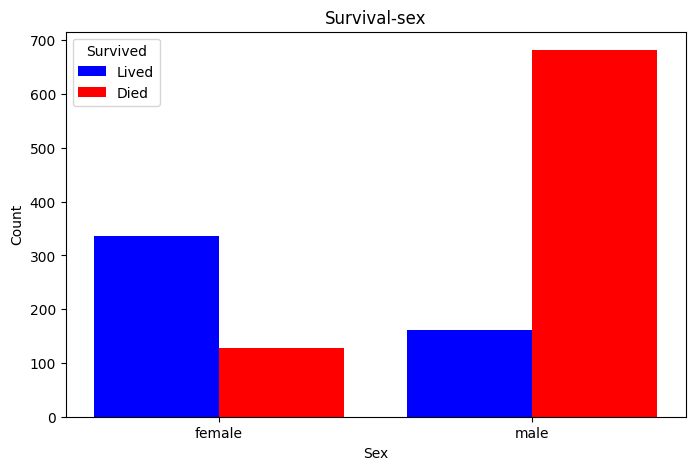

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Get data for `sex`
df_sex = aggregated_data["sex"].sort_values(by="sex")

# Separate groups to present
survived = df_sex[df_sex["survived"] == 1]
died = df_sex[df_sex["survived"] == 0]

plt.figure(figsize=(8, 5))

# Width of the boxes
bar_width = 0.4
x_labels = np.arange(len(df_sex["sex"].unique()))  # Pozycje na osi X

# Draw bars for survived/dead
plt.bar(x_labels - bar_width / 2, survived["count"], color="blue", width=bar_width, label="Lived")
plt.bar(x_labels + bar_width / 2, died["count"], color="red", width=bar_width, label="Died")

# Plot labels
plt.xticks(x_labels, sorted(df_sex["sex"].unique()))

# Describe the cart
plt.title("Survival-sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Survived")

plt.show()


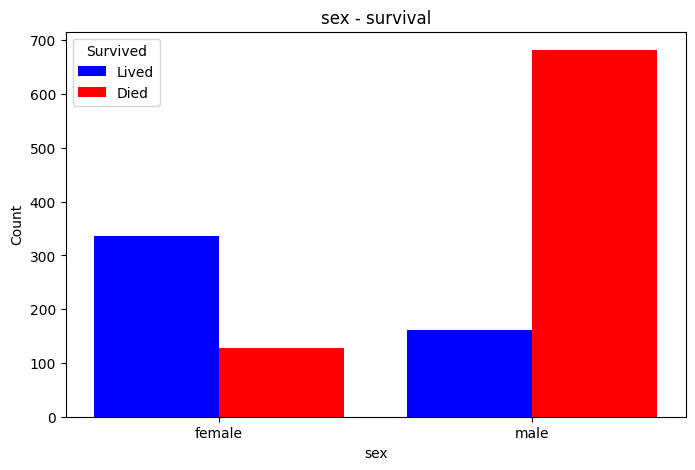

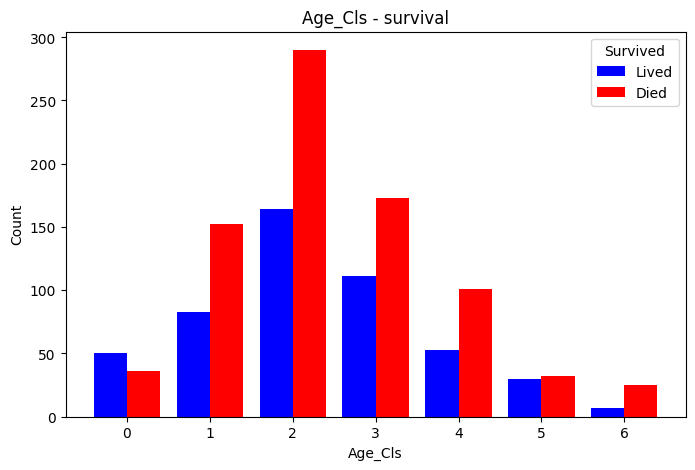

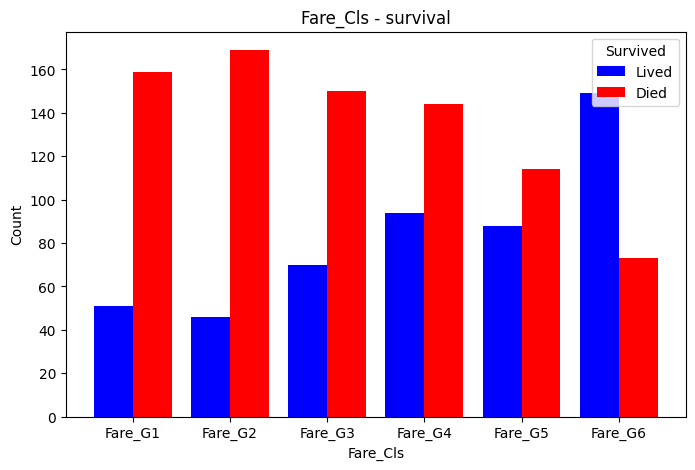

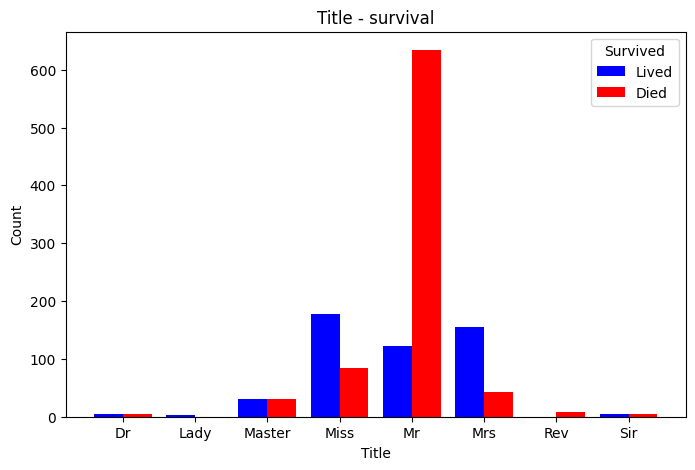

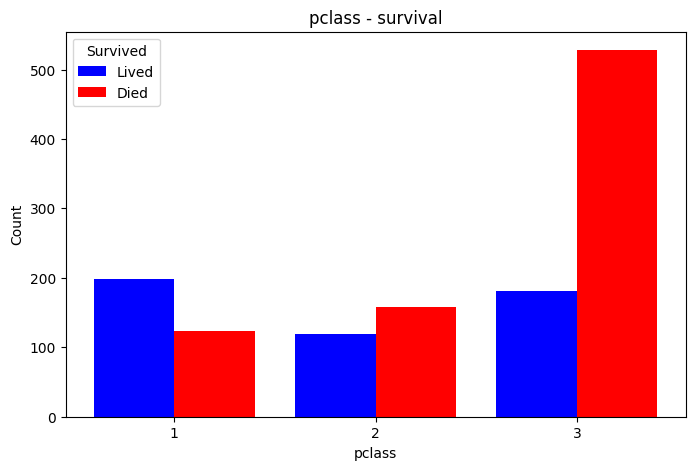

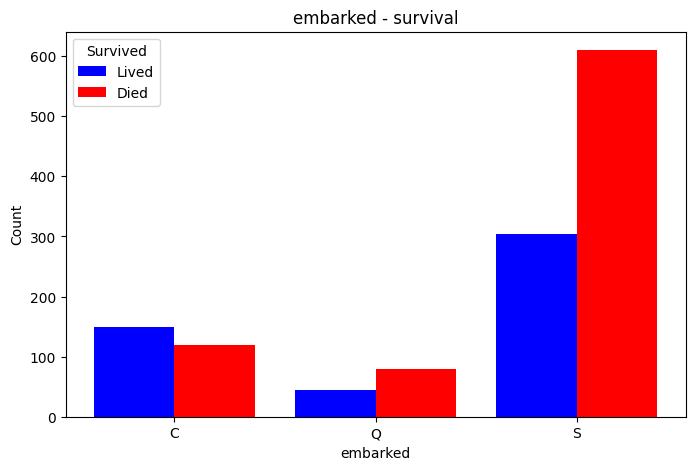

In [35]:
import matplotlib.pyplot as plt
import numpy as np

columns_to_plot = ["sex", "Age_Cls", "Fare_Cls", "Title", "pclass", "embarked"]

for col_name in columns_to_plot:
    df_col = aggregated_data[col_name].sort_values(by=col_name)

    # Check if we have data
    if df_col.empty:
        continue

    survived = df_col[df_col["survived"] == 1]
    died = df_col[df_col["survived"] == 0]

    plt.figure(figsize=(8, 5))

    # Get values for X
    unique_vals = sorted(df_col[col_name].unique())
    x_labels = np.arange(len(unique_vals))
    bar_width = 0.4

    # Match number of groups with x_labels
    survived_counts = [survived[survived[col_name] == val]["count"].sum() if val in survived[col_name].values else 0 for val in unique_vals]
    died_counts = [died[died[col_name] == val]["count"].sum() if val in died[col_name].values else 0 for val in unique_vals]

    # Draw boxes
    plt.bar(x_labels - bar_width / 2, survived_counts, color="blue", width=bar_width, label="Lived")
    plt.bar(x_labels + bar_width / 2, died_counts, color="red", width=bar_width, label="Died")

    plt.xticks(x_labels, unique_vals)  # add labels on X

    plt.title(f"{col_name} - survival")
    plt.xlabel(col_name)
    plt.ylabel("Count")
    plt.legend(title="Survived")

    plt.show()
